Problem 3 Suppose 𝑦 = ∑25
𝑗=1 𝛽𝑗𝑥
𝑗 + 𝜀, where 𝑥 ∼ 𝑁(0, 1) is independent of 𝜀 ∼ 𝑁(0, 𝜎2
), and
𝛽𝑗 = 0.5 + 0.5𝑗/25. Run a Monte Carlo simulation to estimate (as accurately as possible) the train
and test MSE of a linear regression on the first 𝑝 features 𝑥, … , 𝑥𝑝 with the sample size 𝑛 = 20.
For each 𝜎 ∈ (0.05, 0.3, 0.5, 0.8, 1), plot the test MSE as a function of 𝑝 (take the maximum 𝑝 small
enough to see a U-shaped curve). Do the same for the train MSE. What is the optimal 𝑝 for each
𝜎? Explain this relationship.

# Test error 的U-shape

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
n = 20
d = 25
d_range = range(1, 7, 1)
sigma_range = [0.05, 0.3, 0.5, 0.8, 1]
sigma_x = 1
n_test = 100
n_sims = 500
np.random.seed(5)
beta = np.linspace(0.5, 1, d)

In [4]:
def generate_data_polynomial(n, d, sigma, sigma_x, beta):
    # n: 数据点的数量
    # d: 多项式的最高次数
    # sigma: 噪声项的标准差
    # sigma_x: 输入变量x的缩放因子（标准差）
    # beta: 系数数组，维度应与多项式的次数相匹配
    
    # 生成n个随机的x值，范围为[0, sigma_x)
    x_base = sigma_x * np.random.rand(n)
    
    # 生成X矩阵，其中包含x的1到d次幂
    X = [x_base ** i for i in range(1, d + 1)]
    X = np.column_stack(X)  # 将列表转换成列矩阵形式#生成20*25的矩阵
    
    # 生成服从正态分布的噪声项
    eps = sigma * np.random.randn(n)
    
    # 计算目标值Y，为多项式的计算结果加上噪声项
    Y = X @ beta + eps
    
    # 返回生成的特征矩阵X和目标值向量Y
    return X, Y


In [9]:
# 初始化线性回归模型
model = LinearRegression()

# 用于存储测试集和训练集上的MSE值的字典
mse_test, mse_train = dict(), dict()

# 遍历不同的多项式次数和噪声水平
for d_fit in d_range:  # d_range是多项式次数的范围
    for sigma in sigma_range:  # sigma_range是噪声标准差的范围
        # 为每对(d_fit, sigma)初始化一个空数组来存储MSE值
        mse_test[(d_fit, sigma)] = np.empty(n_sims)
        mse_train[(d_fit, sigma)] = np.empty(n_sims)

# 进行多次模拟
for s in range(n_sims):  # n_sims是模拟的次数
    for sigma in sigma_range:
        # 生成训练数据
        X_train, Y_train = generate_data_polynomial(n, d, sigma, sigma_x, beta)
        for d_fit in d_range:
            # 训练模型，仅使用X_train的前d_fit列（即多项式次数为d_fit）
            model.fit(X_train[:, :d_fit], Y_train)
            
            # 生成测试数据
            X_test, Y_test = generate_data_polynomial(n_test, d, sigma, sigma_x, beta)
            
            # 对测试集进行预测并计算MSE
            Y_pred = model.predict(X_test[:, :d_fit])
            mse_test[(d_fit, sigma)][s] = mean_squared_error(Y_test, Y_pred)
            
            # 对训练集进行预测并计算MSE
            Y_pred = model.predict(X_train[:, :d_fit])
            mse_train[(d_fit, sigma)][s] = mean_squared_error(Y_train, Y_pred)

# 说明：
# n, n_test：分别代表训练集和测试集的数据点数量
# d：生成数据时多项式的实际最高次数
# sigma_x：输入变量x的缩放因子
# beta：多项式的真实系数
# d_range, sigma_range：遍历的多项式次数和噪声水平的范围
# n_sims：模拟的次数，用于计算平均MSE

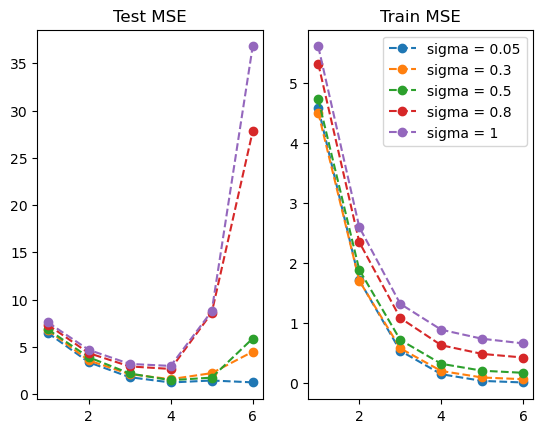

In [12]:
# 创建一个1行2列的子图，分别用于展示测试集和训练集的MSE
fig, (ax_test, ax_train) = plt.subplots(1, 2)

# 遍历每一个噪声水平
for sigma in sigma_range:
    # 对每种多项式次数d_fit，计算在当前sigma下所有模拟的平均MSE
    for d_fit in d_range:
        mse_test[(d_fit, sigma)] = np.mean(mse_test[(d_fit, sigma)])
        mse_train[(d_fit, sigma)] = np.mean(mse_train[(d_fit, sigma)])
    
    # 在测试集的子图上绘制当前sigma下，不同多项式次数的平均MSE
    ax_test.plot(d_range, [mse_test[(d_fit, sigma)] for d_fit in d_range],
                 linestyle='--', marker='o', label='sigma = ' + str(sigma))
    
    # 在训练集的子图上绘制当前sigma下，不同多项式次数的平均MSE
    ax_train.plot(d_range, [mse_train[(d_fit, sigma)] for d_fit in d_range],
                  linestyle='--', marker='o', label='sigma = ' + str(sigma))

# 设置测试集子图的标题
ax_test.title.set_text('Test MSE')
# 设置训练集子图的标题
ax_train.title.set_text('Train MSE')
# 显示图例
plt.legend()

# 说明：
# d_range：多项式次数的范围
# sigma_range：噪声水平的范围
# mse_test, mse_train：分别存储测试集和训练集的MSE
# plt.subplots(1, 2)：创建1行2列的子图
# ax_test.plot和ax_train.plot：分别在测试集和训练集的子图上绘制MSE曲线
# linestyle='--', marker='o'：设置曲线的样式为虚线，数据点为圆圈
# label='sigma = ' + str(sigma)：设置每条曲线的标签为对应的噪声水平


Let 𝑦 = 𝑥 − 2𝑥2 + 𝜀, where 𝑥 and 𝜀 are independent 𝑁(0, 1) random variables.
(a) Set a random seed, and compute the LOOCV errors from fitting the following four models
using least squares on 𝑛 = 100 points:
𝑦 = 𝛽0 + 𝛽1𝑥 + 𝑢, (8)
𝑦 = 𝛽0 + 𝛽1𝑥 + 𝛽2𝑥
2 + 𝑢, (9)
𝑦 = 𝛽0 + 𝛽1𝑥 + 𝛽2𝑥
2 + 𝛽3𝑥
3 + 𝑢, (10)
𝑦 = 𝛽0 + 𝛽1𝑥 + 𝛽2𝑥
2 + 𝛽3𝑥
3 + 𝛽4𝑥
4 + 𝑢. (11)
(12)
Also create a scatterplot of the data.
(b) Repeat (a) using another random seed, and report your results. Are your results the same as
what you got in (a)?
(c) Which of the models in (a) had the smallest LOOCV error? Is this what you expected?
Explain your answer.
(d) Comment on the statistical significance of the coefficient estimates that results from fitting
each of the models in (a) using least squares. Do these results agree with the conclusions
drawn based on the cross-validation results?

# LOOCV

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
from scipy import stats

>>>>>> Random Seed: 1


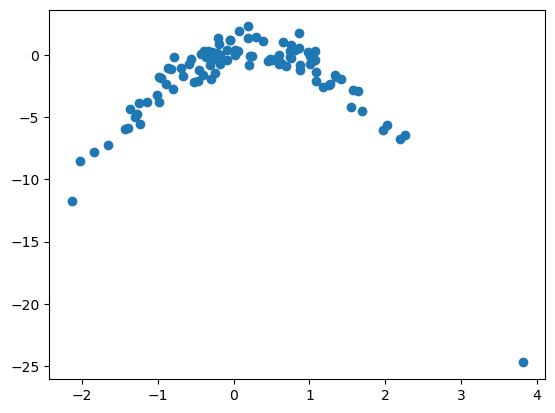

p = 1 , test MSE (CV) = 13.673779708467459
p-values = ['1.00', '0.54']
p = 2 , test MSE (CV) = 0.7300916984645851
p-values = ['1.00', '0.00', '0.00']
p = 3 , test MSE (CV) = 0.7459009632319505
p-values = ['1.00', '0.00', '0.00', '0.93']
p = 4 , test MSE (CV) = 1.8855863470441663
p-values = ['1.00', '0.00', '0.00', '0.59', '0.58']
>>>>>> Random Seed: 2


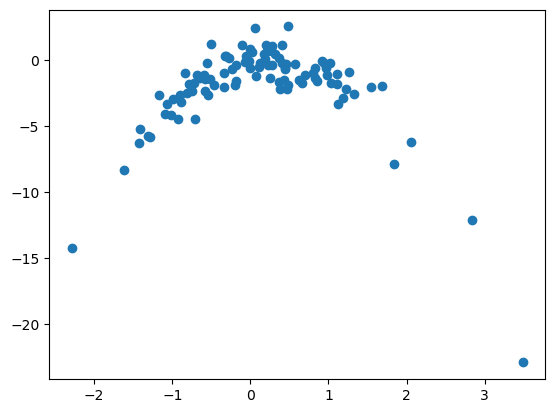

p = 1 , test MSE (CV) = 13.050547106870681
p-values = ['1.00', '0.28']
p = 2 , test MSE (CV) = 1.256369259979219
p-values = ['1.00', '0.00', '0.00']
p = 3 , test MSE (CV) = 1.4507710170364714
p-values = ['1.00', '0.00', '0.00', '0.71']
p = 4 , test MSE (CV) = 1.644411792954774
p-values = ['1.00', '0.00', '0.00', '0.15', '0.13']


In [25]:
# 设置样本数量
n = 100

# 初始化线性回归模型
model = LinearRegression()

# 对两个不同的随机种子进行循环
for seed in [1, 2]:
    # 设置随机数生成器的种子，保证实验可重复
    np.random.default_rng(seed)
    print(">>>>>> Random Seed: " + str(seed))
    
    # 生成随机数据
    x = np.random.normal(size=n)  # 生成n个服从正态分布的随机x值
    y = x - 2 * x**2 + np.random.normal(size=n)  # 生成对应的y值，包含x的线性和二次项以及额外的噪声
    
    # 绘制x和y的散点图
    plt.scatter(x, y)
    plt.show()
    
    # 对1到4次多项式进行循环
    for p in range(1, 5):
        # 生成多项式特征
        #转置是为了让数组的每一列对应一个多项式项（从0次幂到p次幂），每一行对应一个数据点的所有多项式项的值。
        xp = np.transpose([x**i for i in range(0, p + 1)])
        
        # 使用留一交叉验证（LOOCV）计算MSE #cross-validation里model,x,y,cv折数，scoring='neg_mean_squared_error'， return_train_score=True
        cv = cross_validate(model, xp, y, cv=n, scoring='neg_mean_squared_error', return_train_score=True)
        
        # 训练模型并计算均方误差（MSE）
        model.fit(xp, y)
        mse = mean_squared_error(y, model.predict(xp))
        
        # 计算标准误差
        se = np.sqrt(np.diag(np.linalg.inv(np.dot(xp.T, xp))) * mse)
        
        # 计算t统计量和p值
        t_stats = model.coef_ / se
        p_values = [2 * (1 - stats.t.cdf(np.abs(t), n - p)) for t in t_stats]
        
        # 打印多项式次数、交叉验证的测试MSE和p值 #np.mean(cv["test_score"])
        print('p =', p, ', test MSE (CV) =', -np.mean(cv['test_score']))
        print('p-values = ' + str([f"{p_val:.2f}" for p_val in p_values]))

# 说明：
# np.random.normal(size=n) 生成n个服从标准正态分布的随机数
# np.transpose() 对生成的多项式特征进行转置，以便与y进行线性回归分析
# cross_validate() 使用留一交叉验证（LOOCV）来评估模型性能
# np.linalg.inv() 计算矩阵的逆，用于计算系数的标准误差
# stats.t.cdf() 计算t分布的累积分布函数，用于计算p值
